In [17]:
import torch
from torch import nn
torch.cuda.is_available()
device = 'cpu'
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples
import os
from torchgeo.datasets import RasterDataset
import pylab as plt
import numpy as np

In [5]:
class BengaluruDataset(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """

    filename_glob = "*.tif"
    

class BengaluruDatasetLabels(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """
    is_image = False
    filename_glob = "*.tif"

In [7]:
# base path of the dataset
TRAIN_PATH = os.path.join("Data", "Train")
TEST_PATH = os.path.join("Data", "Test")

tr_labels = lambda x: x[:,0,:,:].long()

class TransBengaluruImages(nn.Module):
    """."""

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        inputs["image"] -= inputs["image"].min()
        inputs["image"] /= inputs["image"].max()
        
        return inputs
    
class TransBengaluruLabels(nn.Module):
    """."""

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        # Batch
        if inputs["mask"].ndim == 4:
            inputs["mask"] = (inputs["mask"][:,0,:,:]).long()
        # Sample
        else:
            inputs["mask"] = (inputs["mask"][0,:,:]).long()
        
        return inputs

ds = BengaluruDataset(os.path.join(TRAIN_PATH, "Images"), transforms=TransBengaluruImages())
la = BengaluruDatasetLabels(os.path.join(TRAIN_PATH, "Labels"), transforms=TransBengaluruLabels())

train_ds = ds & la

ds2 = BengaluruDataset(os.path.join(TEST_PATH, "Images"), transforms=TransBengaluruImages())
la2 = BengaluruDatasetLabels(os.path.join(TEST_PATH, "Labels"), transforms=TransBengaluruLabels())

test_ds = ds2 & la2

In [50]:
la2._

False

In [53]:
from osgeo import gdal
ds = gdal.Open('Data/Test/Labels/Labelled_Post_P02.tif')

In [61]:
ds.GetGeoTransform()

(779700.306997573,
 1.200444240953174,
 0.0,
 1480999.4403944414,
 0.0,
 -1.2004442443570293)

In [62]:
sample

defaultdict(list,
            {'image': tensor([[[[0.1426, 0.1482, 0.1496,  ..., 0.1482, 0.1468, 0.1440],
                       [0.1369, 0.1383, 0.1440,  ..., 0.1440, 0.1412, 0.1440],
                       [0.1383, 0.1383, 0.1412,  ..., 0.1440, 0.1454, 0.1454],
                       ...,
                       [0.1482, 0.1482, 0.1412,  ..., 0.1637, 0.1651, 0.1666],
                       [0.1454, 0.1510, 0.1440,  ..., 0.1666, 0.1609, 0.1680],
                       [0.1482, 0.1482, 0.1454,  ..., 0.1623, 0.1623, 0.1680]],
             
                      [[0.1179, 0.1169, 0.1220,  ..., 0.1169, 0.1190, 0.1098],
                       [0.1057, 0.1047, 0.1128,  ..., 0.1149, 0.1159, 0.1128],
                       [0.1139, 0.1159, 0.1159,  ..., 0.1128, 0.1210, 0.1190],
                       ...,
                       [0.1087, 0.1098, 0.1026,  ..., 0.1578, 0.1486, 0.1640],
                       [0.1118, 0.1139, 0.1098,  ..., 0.1599, 0.1486, 0.1578],
                       [0.1128, 0

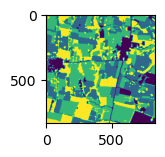

In [59]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

def read_geotiff(filename):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr, ds

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)

nlcd01_arr, nlcd01_ds = read_geotiff('Data/Test/Labels/Labelled_Post_P02.tif')
#nlcd16_arr, nlcd16_ds = read_geotiff("nlcd2016_clipped.tif")
#
#nlcd_changed = np.where(nlcd01_arr != nlcd16_arr, 1, 0)
#
#write_geotiff("nlcd_changed.tif", nlcd_changed, nlcd01_ds)
#
plt.subplot(311)
plt.imshow(nlcd01_arr)
#
#plt.subplot(312)
#plt.imshow(nlcd16_arr)
#
#plt.subplot(313)
#plt.imshow(nlcd_changed)
#
plt.show()

In [45]:
DATASET_SIZE = 2048
BATCH_SIZE = 128
IMG_SIZE = 128


train_sampler = RandomGeoSampler(train_ds, size=IMG_SIZE, length=DATASET_SIZE)

# test_sampler = RandomGeoSampler(test_ds, size=IMG_SIZE, length=DATASET_SIZE)

test_sampler = GridGeoSampler(test_ds, size=IMG_SIZE, stride=110, roi=None)


train_dl = DataLoader(train_ds, BATCH_SIZE, sampler=train_sampler, collate_fn=stack_samples)
test_dl  = DataLoader(test_ds, 1, sampler=test_sampler, collate_fn=stack_samples)

In [21]:
n_grid = 8
print((n_grid*128-800) / n_grid)

28.0


In [27]:
test_dl.

In [9]:
def visualize(image, mask):
    """PLot images in one row."""
    fig = plt.figure(figsize=(16, 8))
    #plt.imshow(image[0].transpose(0,2), vmin=0, vmax=1)
    image /= image.numpy().max()
    plt.imshow(image, cmap='gray')
    #plt.imshow(image[0])
    if mask.max()>0:
        plt.imshow(mask/9, alpha=0.25, vmin=0, vmax=1, cmap='Set1', interpolation='nearest')
        
    cb = plt.colorbar(cmap='Dark2', ticks=np.linspace(0.5/9, 3.5/9, 4), boundaries=np.linspace(0,4/9,5))
    cb.set_ticklabels(['Background', 'Soil', 'Herbaceous', 'Woody'])
    plt.show()

In [10]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)

        self.upconv4 = self.expand_block(256, 128, 3, 1)
        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [13]:
unet = torch.load('unet_128px-4ly.pt', map_location=torch.device('cpu'))
unet.eval();

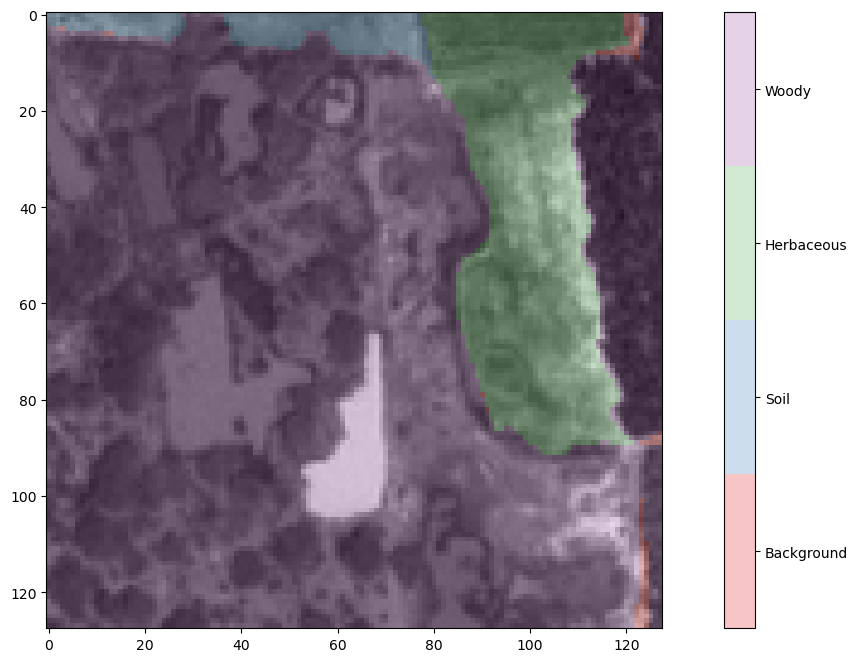

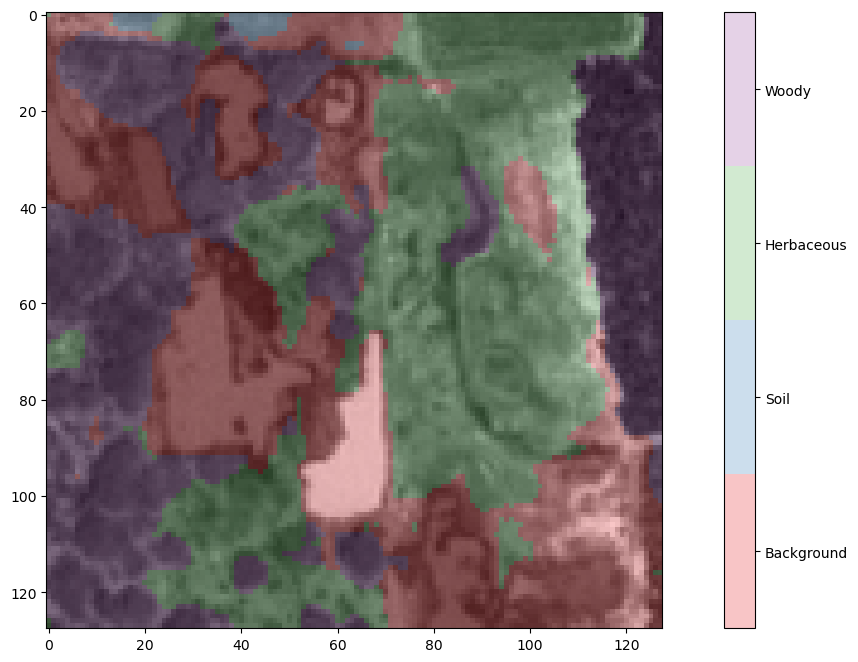

In [35]:
for sample in train_dl:
    idx = 0
    image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
    target = sample["mask"][idx, :, :]
    pred = unet(sample["image"]).cpu()[0]

    visualize(image, target)
    visualize(image, torch.argmax(pred, 0))
    break

In [38]:
sample['mask'].shape

torch.Size([128, 128, 128])

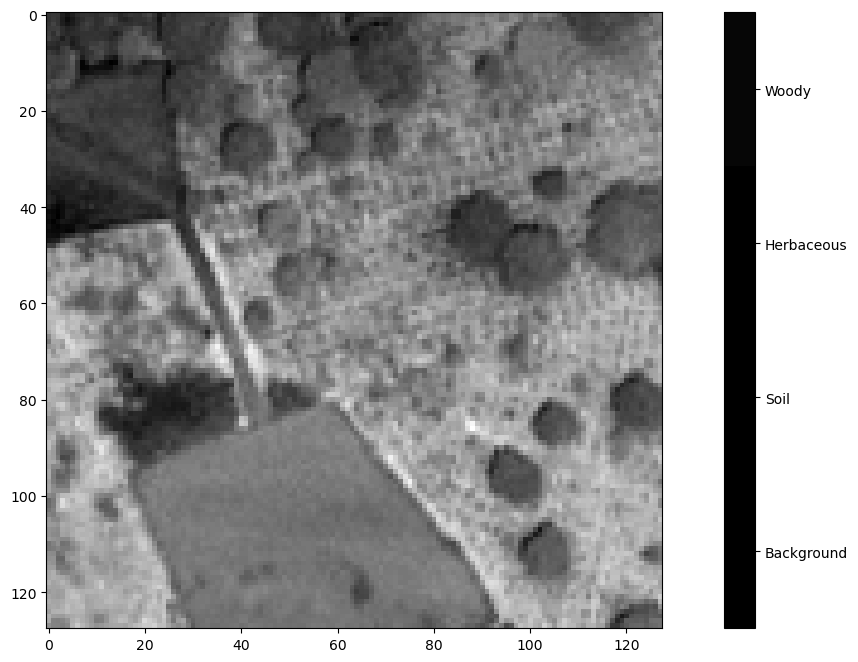

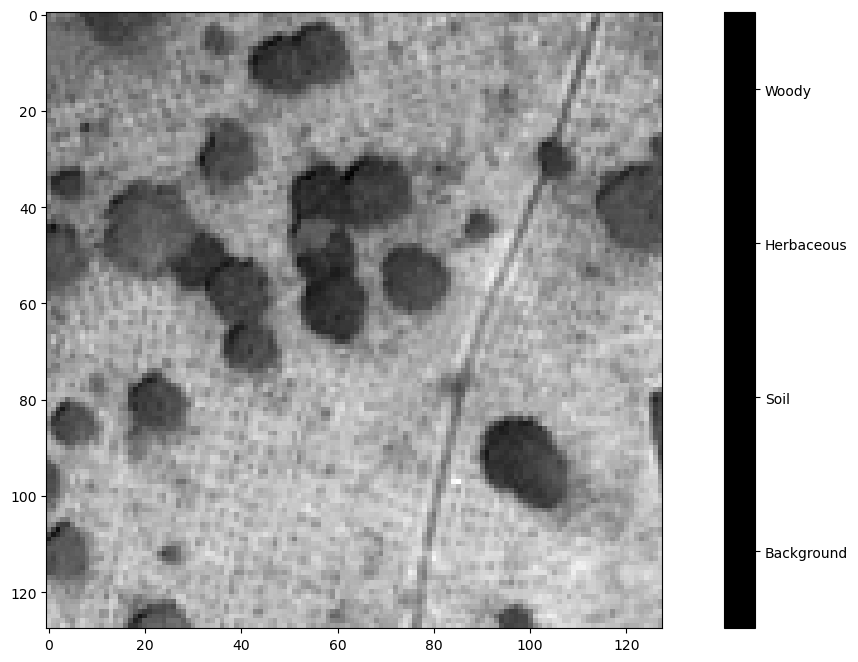

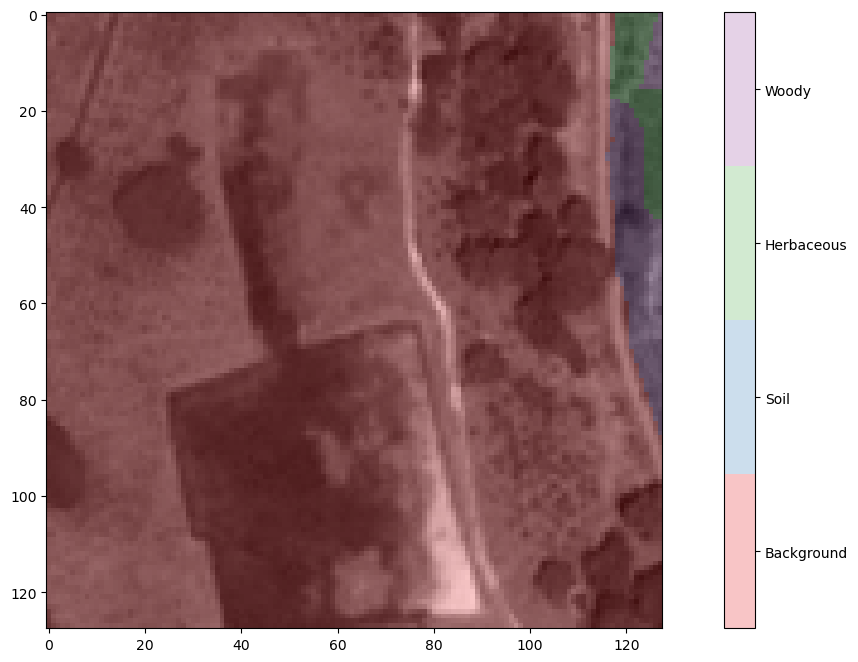

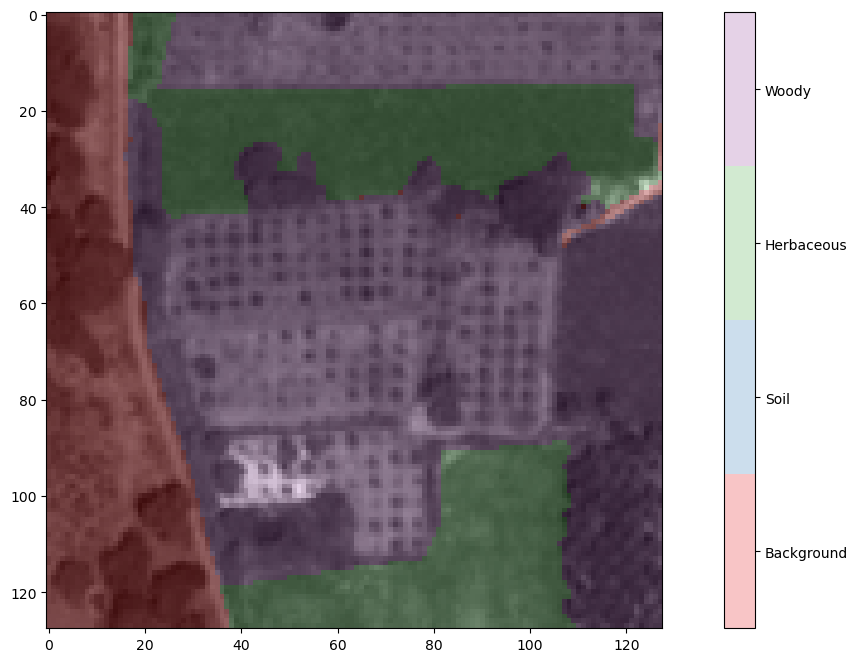

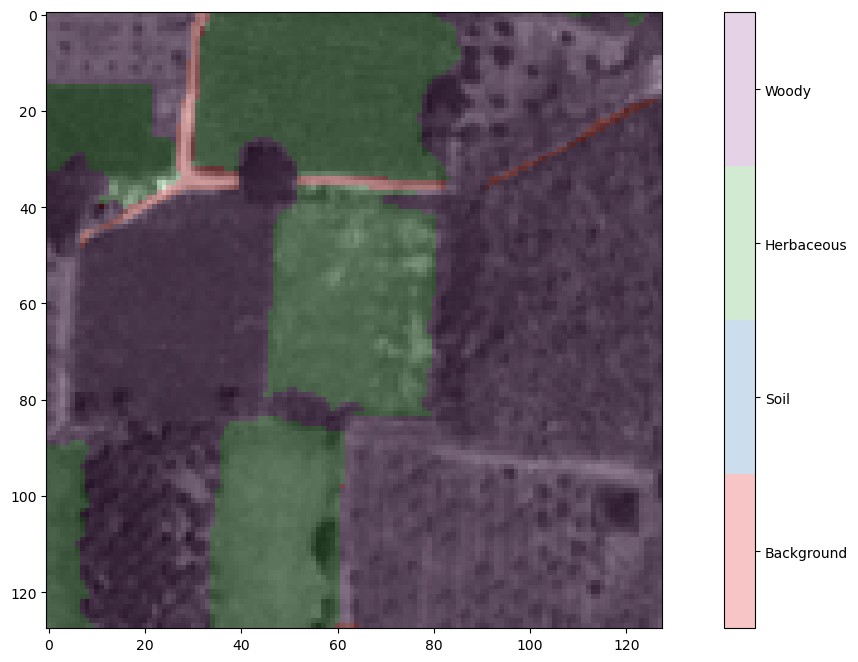

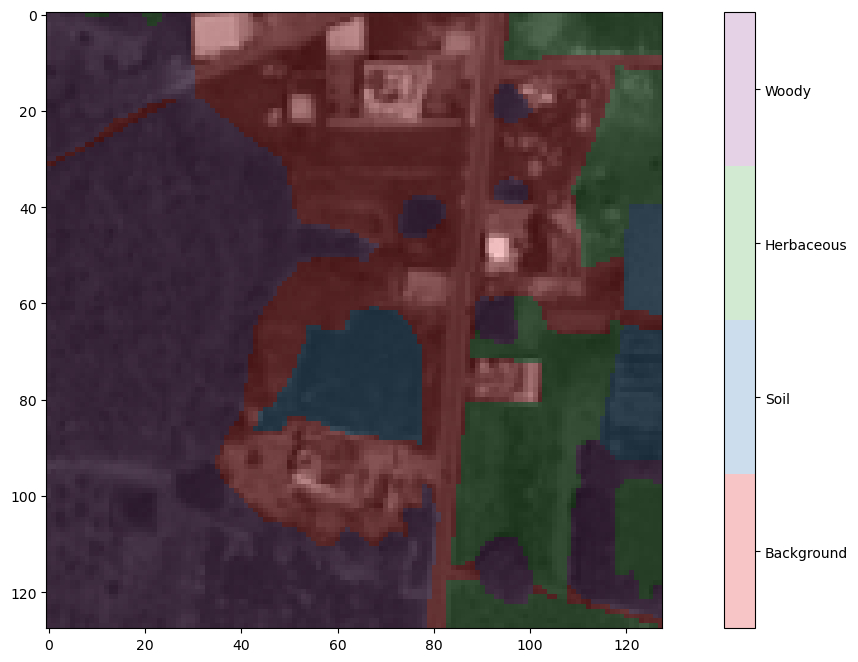

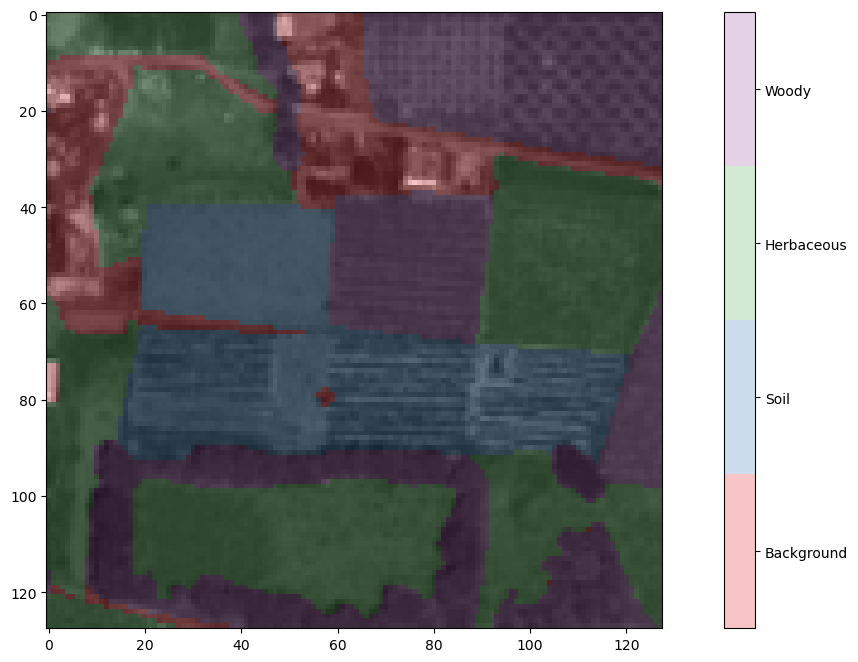

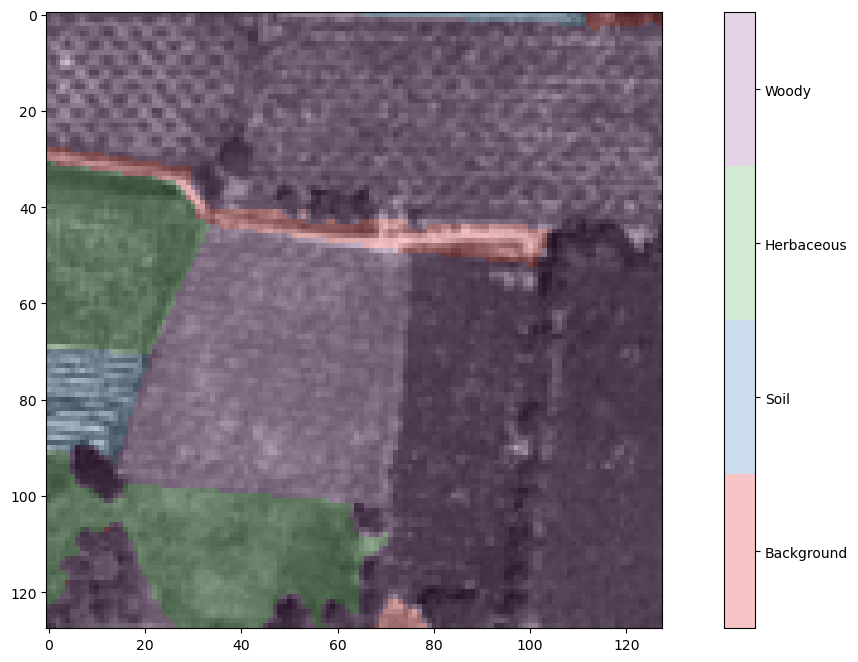

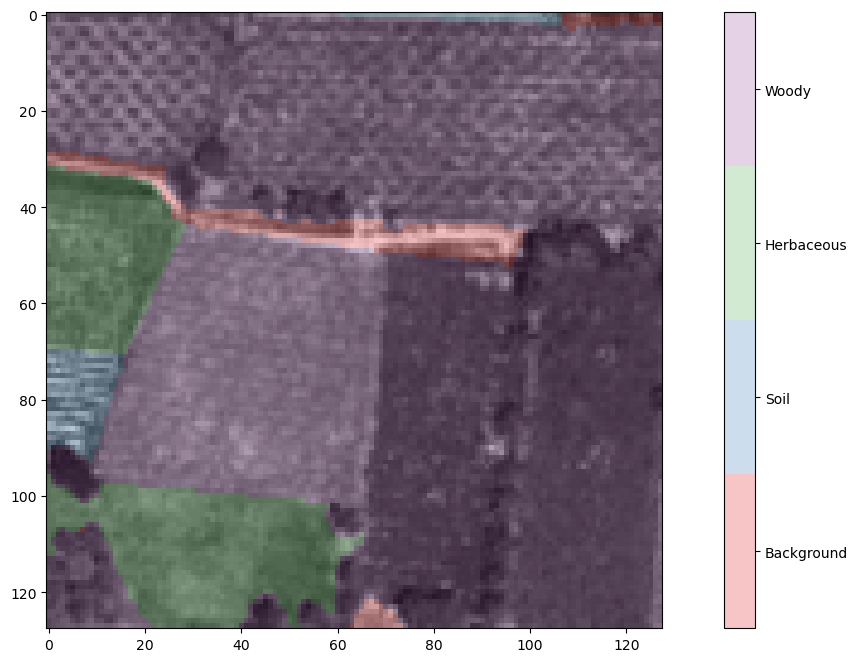

In [44]:
a = 1
for sample in test_dl:
    a += 1
    if a > 10:
        break
    
    idx = 0
    image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
    target = sample["mask"][idx, :, :]
    pred = unet(sample["image"]).cpu()[0]

    visualize(image, target)
    #visualize(image, torch.argmax(pred, 0))

In [46]:
sample

defaultdict(list,
            {'image': tensor([[[[0.1426, 0.1482, 0.1496,  ..., 0.1482, 0.1468, 0.1440],
                       [0.1369, 0.1383, 0.1440,  ..., 0.1440, 0.1412, 0.1440],
                       [0.1383, 0.1383, 0.1412,  ..., 0.1440, 0.1454, 0.1454],
                       ...,
                       [0.1482, 0.1482, 0.1412,  ..., 0.1637, 0.1651, 0.1666],
                       [0.1454, 0.1510, 0.1440,  ..., 0.1666, 0.1609, 0.1680],
                       [0.1482, 0.1482, 0.1454,  ..., 0.1623, 0.1623, 0.1680]],
             
                      [[0.1179, 0.1169, 0.1220,  ..., 0.1169, 0.1190, 0.1098],
                       [0.1057, 0.1047, 0.1128,  ..., 0.1149, 0.1159, 0.1128],
                       [0.1139, 0.1159, 0.1159,  ..., 0.1128, 0.1210, 0.1190],
                       ...,
                       [0.1087, 0.1098, 0.1026,  ..., 0.1578, 0.1486, 0.1640],
                       [0.1118, 0.1139, 0.1098,  ..., 0.1599, 0.1486, 0.1578],
                       [0.1128, 0